# Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator <br>-- Correctness Testing --

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for variable density visco- acoustics using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *skew self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. There are three notebooks in this series:

##### 1. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Nonlinear Ops
- Implement the nonlinear modeling operations. 
- [ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb)

##### 2. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Linearized Ops
- Implement the linearized (Jacobian) ```forward``` and ```adjoint``` modeling operations.
- [ssa_02_iso_implementation2.ipynb](ssa_02_iso_implementation2.ipynb)

##### 3. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Correctness Testing
- Tests the correctness of the implemented operators.
- [ssa_03_iso_correctness.ipynb](ssa_03_iso_correctness.ipynb)

There are similar series of notebooks implementing and testing operators for VTI and TTI anisotropy ([README.md](README.md)).

Below we describe a suite of unit tests that prove correctness for our *skew self adjoint* operators.

## Outline 
1. Define symbols
2. Definition of correctness tests 
3. Analytic response in the far field 
4. Modeling operator linearity test, with respect to source 
5. Modeling operator adjoint test, with respect to source 
6. Nonlinear operator linearization test, with respect to model 
7. Jacobian operator linearity test, with respect to model 
8. Jacobian operator adjoint test, with respect to model 
9. Skew symmetry test for shifted derivatives 
10. References 


## Table of symbols

We show the symbols here relevant to the implementation of the linearized operators.

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $\overleftarrow{\partial_t}$ | shifted first derivative wrt $t$ | shifted 1/2 sample backward in time |
| $\partial_{tt}$ | centered second derivative wrt $t$ | centered in time |
| $\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 sample forward in space |
| $\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 sample backward in space |
| $m(x,y,z)$ | Total P wave velocity ($m_0+\delta m$) | function of space |
| $m_0(x,y,z)$ | Reference P wave velocity    | function of space |
| $\delta m(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u(t,x,y,z)$ | Total pressure wavefield ($u_0+\delta u$)| function of time and space |
| $u_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $\delta r(t,x,y,z)$ | Receiver wavefield perturbation | function of time, localized in space to receiver locations |
| $F[m]\ q$ | Forward linear modeling operator | Nonlinear in $m$, linear in $q, s$: $\quad$ maps $q \rightarrow s$ |
| $\bigl( F[m] \bigr)^\top\ s$ | Adjoint linear modeling operator | Nonlinear in $m$, linear in $q, s$: $\quad$ maps $s \rightarrow q$ |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta m$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta m \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta m$ |
| $\Delta_t, \Delta_x, \Delta_y, \Delta_z$ | sampling rates for $t, x, y , z$ | $t, x, y , z$ |  

## A word about notation 

We use the arrow symbols over derivatives $\overrightarrow{\partial_x}$ as a shorthand notation to indicate that the derivative is taken at a shifted location. For example:

- $\overrightarrow{\partial_x}\ u(t,x,y,z)$ indicates that the $x$ derivative of $u(t,x,y,z)$ is taken at $u(t,x+\frac{\Delta x}{2},y,z)$.

- $\overleftarrow{\partial_z}\ u(t,x,y,z)$ indicates that the $z$ derivative of $u(t,x,y,z)$ is taken at $u(t,x,y,z-\frac{\Delta z}{2})$.

- $\overleftarrow{\partial_t}\ u(t,x,y,z)$ indicates that the $t$ derivative of $u(t,x,y,z)$ is taken at $u(t-\frac{\Delta_t}{2},x,y,z)$.

We usually drop the $(t,x,y,z)$ notation from wavefield variables unless required for clarity of exposition, so that $u(t,x,y,z)$ becomes $u$.

## Definition of correctness tests

We believe that if an operator passes the following suite of unit tests, it can be considered to be *righteous*.

## 1. Analytic response in the far field
Test that data generated in a wholespace matches analogous analytic data away from the near field. We re-use the material shown in the [examples/seismic/acoustic/accuracy.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/acoustic/accuracy.ipynb) notebook. 
<br>

## 2. Modeling operator linearity test, with respect to source
For random vectors $s$ and $r$, prove:

$$
\begin{aligned}
F[m]\ (\alpha\ s) &\approx \alpha\ F[m]\ s \\[5pt]
F[m]^\top (\alpha\ r) &\approx \alpha\ F[m]^\top r \\[5pt]
\end{aligned}
$$
## 3. Modeling operator adjoint test, with respect to source
For random vectors $s$ and $r$, prove:

$$
r \cdot F[m]\ s \approx s \cdot F[m]^\top r
$$

## 4. Nonlinear operator linearization test, with respect to model
For initial velocity model $m$ and random perturbation $\delta m$ prove that the $L_2$ norm error in the linearization $E(h)$ is second order (decreases quadratically) with the magnitude of the perturbation.

$$
E(h) = \biggl\|\ f(m+h\ \delta m) - f(m) - h\ \nabla F[m; q]\ \delta m\ \biggr\|
$$

One way to do this is to run a suite of $h$ values decreasing by a factor of $\gamma$, and prove the error decreases by a factor of $\gamma^2$:  

$$
\frac{E\left(h\right)}{E\left(h/\gamma\right)} \approx \gamma^2
$$

Elsewhere in Devito tutorials, this relation is proven by fitting a line to a sequence of $E(h)$ for various $h$ and showing second order error decrease. We employ this strategy here.

## 5. Jacobian operator linearity test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\begin{aligned}
\nabla F[m; q]\ (\alpha\ \delta m) &\approx \alpha\ \nabla F[m; q]\ \delta m \\[5pt]
(\nabla F[m; q])^\top (\alpha\ \delta r) &\approx \alpha\ (\nabla F[m; q])^\top \delta r
\end{aligned}
$$

## 6. Jacobian operator adjoint test, with respect to model perturbation and receiver wavefield perturbation 
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\delta r \cdot \nabla F[m; q]\ \delta m \approx \delta m \cdot (\nabla F[m; q])^\top \delta r
$$

## 7. Skew symmetry for shifted derivatives
In addition to these tests, recall that in the first notebook ([ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb)) we implemented a unit test that demonstrates skew symmetry of the Devito generated shifted derivatives. We include that test in our suite of unit tests for completeness. 

Ensure for random $x_1, x_2$ that Devito shifted derivative operators $\overrightarrow{\partial_x}$ and $\overrightarrow{\partial_x}$ are skew symmetric by verifying the following dot product test.

$$
x_2 \cdot \left( \overrightarrow{\partial_x}\ x_1 \right) \approx -\ 
x_1 \cdot \left( \overleftarrow{\partial_x}\ x_2 \right) 
$$


## Implementation of correctness tests

Below we implement the correctness tests described above. These tests are copied from standalone tests that run in the Devito project *continuous integration* (CI) pipeline via the script ```test_iso_wavesolver.py```. We will implement the test methods in one cell and then call from the next cell to verify correctness, but note that a wider variety of parameterization is tested in the CI pipeline.

For these tests we use the convenience functions implemented in ```operators.py``` and ```wavesolver.py``` rather than implement the operators in the notebook as we have in the first two notebooks in this series. Please review the source to compare with our notebook implementations:
- [operators.py](operators.py)
- [wavesolver.py](wavesolver.py)
- [test_wavesolver_iso.py](test_wavesolver_iso.py)

**Important note:** you must run these notebook cells in order, because some cells have dependencies on state initialized in previous cells.

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [1]:
from scipy.special import hankel2
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis, Model, AcquisitionGeometry
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.skew_self_adjoint import (acoustic_ssa_setup, setup_w_over_q,
                                                SsaIsoAcousticWaveSolver)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set the default language to openmp
configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

## 1. Analytic response in the far field
Test that data generated in a wholespace matches analogous analytic data away from the near field. We copy/modify the material shown in the [examples/seismic/acoustic/accuracy.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/acoustic/accuracy.ipynb) notebook.

#### Analytic solution for the 2D acoustic wave equation

$$
\begin{aligned}
u_s(r, t) &= \frac{1}{2\pi} \int_{-\infty}^{\infty} \bigl\{ -i\ \pi\ H_0^{(2)}\left(k r \right)\ 
q(\omega)\ e^{i\omega t}\ d\omega\bigr\}\\[10pt]
r &= \sqrt{(x_{src} - x_{rec})^2+(z_{src} - z_{rec})^2}
\end{aligned}
$$

where $H_0^{(2)}$ is the Hankel function of the second kind, $F(\omega)$ is the Fourier spectrum of the source time function at angular frequencies $\omega$ and $k = (\omega\ /\ v)$ is the wavenumber. We look at the analytical and numerical solution at a single grid point.

Note that we use a custom discretization for the analytic test that is much finer both temporally and spatially.

In [2]:
# Define the analytic response
def analytic_response(fpeak, time_axis, src_coords, rec_coords, v):
    nt = time_axis.num
    dt = time_axis.step
    v0 = v.data[0,0]
    sx, sz = src_coords[0, :]
    rx, rz = rec_coords[0, :]
    ntpad = 20 * (nt - 1) + 1
    tmaxpad = dt * (ntpad - 1)
    time_axis_pad = TimeAxis(start=tmin, stop=tmaxpad, step=dt)
    timepad = np.linspace(tmin, tmaxpad, ntpad)
    print(time_axis)
    print(time_axis_pad)
    srcpad = RickerSource(name='srcpad', grid=v.grid, f0=fpeak, npoint=1, 
                          time_range=time_axis_pad, t0w=t0w)
    nf = int(ntpad / 2 + 1)
    fnyq = 1.0 / (2 * dt)
    df = 1.0 / tmaxpad
    faxis = df * np.arange(nf)

    # Take the Fourier transform of the source time-function
    R = np.fft.fft(srcpad.wavelet[:])
    R = R[0:nf]
    nf = len(R)

    # Compute the Hankel function and multiply by the source spectrum
    U_a = np.zeros((nf), dtype=complex)
    for a in range(1, nf - 1):
        w = 2 * np.pi * faxis[a] 
        r = np.sqrt((rx - sx)**2 + (rz - sz)**2)
        U_a[a] = -1j * np.pi * hankel2(0.0,  w * r / v0) * R[a]

    # Do inverse fft on 0:dt:T and you have analytical solution
    U_t = 1.0/(2.0 * np.pi) * np.real(np.fft.ifft(U_a[:], ntpad))

    # Note that the analytic solution is scaled by dx^2 to convert to pressure
    return (np.real(U_t) * (dx**2))

In [3]:
#NBVAL_INGNORE_OUTPUT

# Setup time / frequency
nt = 1001
dt = 0.1
tmin = 0.0
tmax = dt * (nt - 1)
fpeak = 0.090
t0w = 1.0 / fpeak
omega = 2.0 * np.pi * fpeak
time_axis = TimeAxis(start=tmin, stop=tmax, step=dt)
time = np.linspace(tmin, tmax, nt)

# Model
space_order = 8
npad = 50
dx, dz = 0.5, 0.5
nx, nz = 801, 801
shape = (nx, nz)
spacing = (dx, dz)
origin = (0., 0.)

dtype = np.float64
qmin = 0.1
qmax = 100000
v0 = 1.5*np.ones(shape)
b0 = 1.0*np.ones(shape)

# Model
init_damp = lambda func, nbl: setup_w_over_q(func, omega, qmin, qmax, npad, sigma=0)
model = Model(origin=origin, shape=shape, vp=v0, b=b0, spacing=spacing, nbl=npad,
              space_order=space_order, bcs=init_damp, dtype=dtype, dt=dt)

# Source and reciver coordinates 
src_coords = np.empty((1, 2), dtype=dtype)
rec_coords = np.empty((1, 2), dtype=dtype)
src_coords[:, :] = np.array(model.domain_size) * .5
rec_coords[:, :] = np.array(model.domain_size) * .5 + 60

geometry = AcquisitionGeometry(model, rec_coords, src_coords,
                               t0=0.0, tn=tmax, src_type='Ricker',
                               f0=fpeak)
# Solver setup
solver = SsaIsoAcousticWaveSolver(model, geometry, space_order=space_order)

# Numerical solution
recNum, uNum, _ = solver.forward(dt=dt)

# Analytic solution
uAnaPad = analytic_response(fpeak, time_axis, src_coords, rec_coords, model.vp)
uAna = uAnaPad[0:nt]

# Compute RMS and difference
diff = (recNum.data - uAna)
nrms = np.max(np.abs(recNum.data))
arms = np.max(np.abs(uAna))
drms = np.max(np.abs(diff))

print("\nMaximum absolute numerical,analytic,diff; %+12.6e %+12.6e %+12.6e" % (nrms, arms, drms))

# This isnt a very strict tolerance ...
tol = 0.1
assert np.allclose(diff, 0.0, atol=tol)

nmin, nmax = np.min(recNum.data), np.max(recNum.data)
amin, amax = np.min(uAna), np.max(uAna)

print("")
print("Numerical min/max; %+12.6e %+12.6e" % (nmin, nmax))
print("Analytic  min/max; %+12.6e %+12.6e" % (amin, amax))

Operator `WOverQ_Operator` run in 0.02 s
Operator `padfunc` run in 0.35 s
Operator `padfunc` run in 0.01 s
Operator `IsoFwdOperator` run in 17.10 s


TimeAxis: start=0, stop=100, step=0.1, num=1001
TimeAxis: start=0, stop=2000, step=0.1, num=20001

Maximum absolute numerical,analytic,diff; +8.532029e-03 +8.547096e-03 +1.389771e-02

Numerical min/max; -5.350614e-03 +8.532029e-03
Analytic  min/max; -5.323205e-03 +8.547096e-03


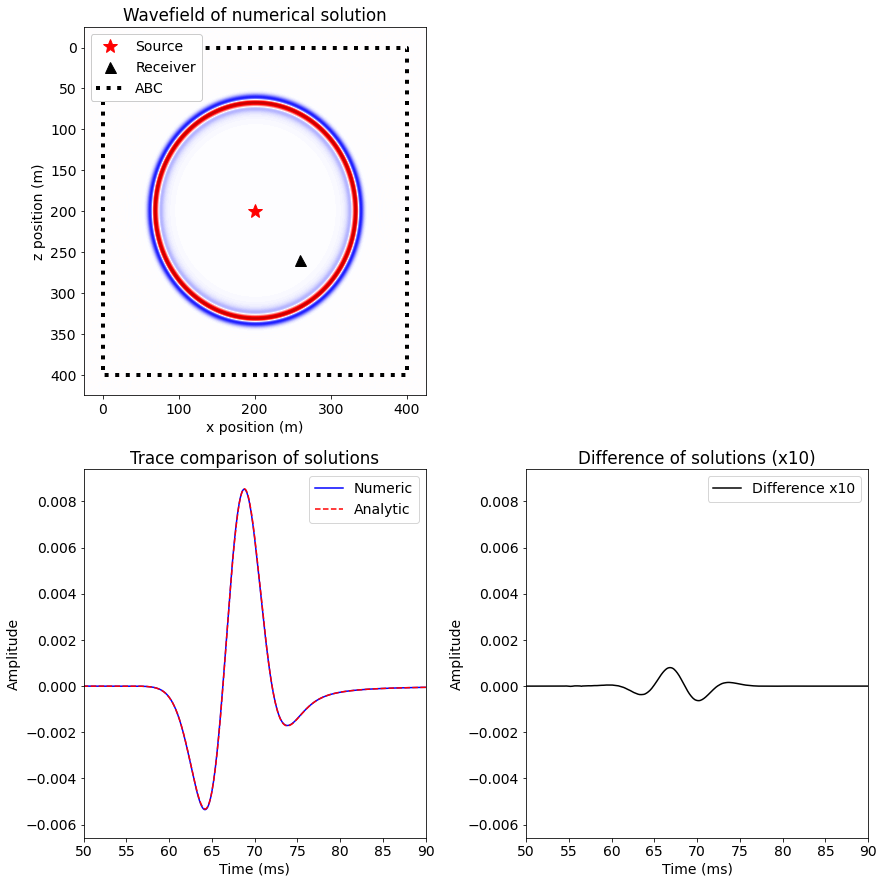

In [4]:
#NBVAL_INGNORE_OUTPUT

# Plot
x1 = origin[0] - model.nbl * model.spacing[0]
x2 = model.domain_size[0] +  model.nbl * model.spacing[0]
z1 = origin[1] - model.nbl * model.spacing[1]
z2 = model.domain_size[1] +  model.nbl * model.spacing[1]

xABC1 = origin[0] 
xABC2 = model.domain_size[0]
zABC1 = origin[1]
zABC2 = model.domain_size[1]

plt_extent = [x1, x2, z2, z1]
abc_pairsX = [xABC1, xABC1, xABC2, xABC2, xABC1] 
abc_pairsZ = [zABC1, zABC2, zABC2, zABC1, zABC1] 

plt.figure(figsize=(12.5,12.5))

# Plot wavefield
plt.subplot(2,2,1)
amax = 1.1 * np.max(np.abs(recNum.data[:]))
plt.imshow(uNum.data[1,:,:], vmin=-amax, vmax=+amax, cmap="seismic",
           aspect="auto", extent=plt_extent)
plt.plot(src_coords[0, 0], src_coords[0, 1], 'r*', markersize=15, label='Source') 
plt.plot(rec_coords[0, 0], rec_coords[0, 1], 'k^', markersize=11, label='Receiver') 
plt.plot(abc_pairsX, abc_pairsZ, 'black', linewidth=4, linestyle=':', 
         label="ABC")
plt.legend(loc="upper left", bbox_to_anchor=(0.0, 0.9, 0.35, .1), framealpha=1.0)
plt.xlabel('x position (m)')
plt.ylabel('z position (m)')
plt.title('Wavefield of numerical solution')
plt.tight_layout()

# Plot trace
plt.subplot(2,2,3)
plt.plot(time, recNum.data[:, 0], '-b', label='Numeric')
plt.plot(time, uAna[:], '--r', label='Analytic')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Trace comparison of solutions')
plt.legend(loc="upper right")
plt.xlim([50,90])
plt.ylim([-0.7 * amax, +amax])

plt.subplot(2,2,4)
plt.plot(time, 10 * (recNum.data[:, 0] -  uAna[:]), '-k', label='Difference x10')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Difference of solutions (x10)')
plt.legend(loc="upper right")
plt.xlim([50,90])
plt.ylim([-0.7 * amax, +amax])

plt.tight_layout()
plt.show()

## Reset default shapes for subsequent tests

In [5]:
npad = 10
fpeak = 0.010
qmin = 0.1
qmax = 500.0
tmax = 1000.0
shape = (101, 81)

## 2. Modeling operator linearity test, with respect to source
For random vectors $s$ and $r$, prove:

$$
\begin{aligned}
F[m]\ (\alpha\ s) &\approx \alpha\ F[m]\ s \\[5pt]
F[m]^\top (\alpha\ r) &\approx \alpha\ F[m]^\top r \\[5pt]
\end{aligned}
$$

We first test the forward operator, and in the cell below that the adjoint operator.

In [6]:
#NBVAL_INGNORE_OUTPUT

solver = acoustic_ssa_setup(shape=shape, dtype=dtype, space_order=8, tn=tmax)
src = solver.geometry.src
a = -1 + 2 * np.random.rand()
rec1, _, _ = solver.forward(src)
src.data[:] *= a
rec2, _, _ = solver.forward(src)
rec1.data[:] *= a

# Check receiver wavefeild linearity
# Normalize by rms of rec2, to enable using abolute tolerance below
rms2 = np.sqrt(np.mean(rec2.data**2))
diff = (rec1.data - rec2.data) / rms2
print("\nlinearity forward F %s (so=%d) rms 1,2,diff; "
      "%+16.10e %+16.10e %+16.10e" %
      (shape, 8, np.sqrt(np.mean(rec1.data**2)), np.sqrt(np.mean(rec2.data**2)),
       np.sqrt(np.mean(diff**2))))
tol = 1.e-12
assert np.allclose(diff, 0.0, atol=tol)

Operator `WOverQ_Operator` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.09 s
Operator `IsoFwdOperator` run in 1.04 s
Operator `IsoFwdOperator` run in 0.02 s



linearity forward F (101, 81) (so=8) rms 1,2,diff; +1.5427724700e+00 +1.5427724700e+00 +1.8149444209e-15


In [7]:
#NBVAL_INGNORE_OUTPUT

src0 = solver.geometry.src
rec, _, _ = solver.forward(src0)
a = -1 + 2 * np.random.rand()
src1, _, _ = solver.adjoint(rec)
rec.data[:] = a * rec.data[:]
src2, _, _ = solver.adjoint(rec)
src1.data[:] *= a

# Check adjoint source wavefeild linearity
# Normalize by rms of rec2, to enable using abolute tolerance below
rms2 = np.sqrt(np.mean(src2.data**2))
diff = (src1.data - src2.data) / rms2
print("\nlinearity adjoint F %s (so=%d) rms 1,2,diff; "
      "%+16.10e %+16.10e %+16.10e" %
      (shape, 8, np.sqrt(np.mean(src1.data**2)), np.sqrt(np.mean(src2.data**2)),
       np.sqrt(np.mean(diff**2))))
tol = 1.e-12
assert np.allclose(diff, 0.0, atol=tol)

Operator `IsoFwdOperator` run in 0.03 s
Operator `IsoAdjOperator` run in 0.02 s
Operator `IsoAdjOperator` run in 0.03 s



linearity adjoint F (101, 81) (so=8) rms 1,2,diff; +9.4794966627e+02 +9.4794966627e+02 +1.1085708265e-15


## 3. Modeling operator adjoint test, with respect to source
For random vectors $s$ and $r$, prove:

$$
r \cdot F[m]\ s \approx s \cdot F[m]^\top r
$$

In [8]:
#NBVAL_INGNORE_OUTPUT

src1 = solver.geometry.src
rec1 = solver.geometry.rec

rec2, _, _ = solver.forward(src1)
# flip sign of receiver data for adjoint to make it interesting
rec1.data[:] = rec2.data[:]
src2, _, _ = solver.adjoint(rec1)
sum_s = np.dot(src1.data.reshape(-1), src2.data.reshape(-1))
sum_r = np.dot(rec1.data.reshape(-1), rec2.data.reshape(-1))
diff = (sum_s - sum_r) / (sum_s + sum_r)
print("\nadjoint F %s (so=%d) sum_s, sum_r, diff; %+16.10e %+16.10e %+16.10e" %
      (shape, 8, sum_s, sum_r, diff))
assert np.isclose(diff, 0., atol=1.e-12)

Operator `IsoFwdOperator` run in 0.56 s
Operator `IsoAdjOperator` run in 1.42 s



adjoint F (101, 81) (so=8) sum_s, sum_r, diff; +4.5670017584e+04 +4.5670017584e+04 -1.5931584876e-16


## 4. Nonlinear operator linearization test, with respect to model

For initial velocity model $m$ and random perturbation $\delta m$ prove that the $L_2$ norm error in the linearization $E(h)$ is second order (decreases quadratically) with the magnitude of the perturbation.

$$
E(h) = \biggl\|\ f(m+h\ \delta m) - f(m) - h\ \nabla F[m; q]\ \delta m\ \biggr\|
$$

One way to do this is to run a suite of $h$ values decreasing by a factor of $\gamma$, and prove the error decreases by a factor of $\gamma^2$:  

$$
\frac{E\left(h\right)}{E\left(h/\gamma\right)} \approx \gamma^2
$$

Elsewhere in Devito tutorials, this relation is proven by fitting a line to a sequence of $E(h)$ for various $h$ and showing second order error decrease. We employ this strategy here.

In [9]:
#NBVAL_INGNORE_OUTPUT

src = solver.geometry.src

# Create Functions for models and perturbation
m0 = Function(name='m0', grid=solver.model.grid, space_order=8)
mm = Function(name='mm', grid=solver.model.grid, space_order=8)
dm = Function(name='dm', grid=solver.model.grid, space_order=8)

# Background model
m0.data[:] = 1.5

# Model perturbation, box of (repeatable) random values centered on middle of model
dm.data[:] = 0
size = 5
ns = 2 * size + 1
nx2, nz2 = shape[0]//2, shape[1]//2
np.random.seed(0)
dm.data[nx2-size:nx2+size, nz2-size:nz2+size] = -1 + 2 * np.random.rand(ns, ns)

# Compute F(m + dm)
rec0, u0, summary0 = solver.forward(src, vp=m0)

# Compute J(dm)
rec1, u1, du, summary1 = solver.jacobian(dm, src=src, vp=m0)

# Linearization test via polyfit (see devito/tests/test_gradient.py)
# Solve F(m + h dm) for sequence of decreasing h
dh = np.sqrt(2.0)
h = 0.1
nstep = 7
scale = np.empty(nstep)
norm1 = np.empty(nstep)
norm2 = np.empty(nstep)
for kstep in range(nstep):
    h = h / dh
    mm.data[:] = m0.data + h * dm.data
    rec2, _, _ = solver.forward(src, vp=mm)
    scale[kstep] = h
    norm1[kstep] = 0.5 * np.linalg.norm(rec2.data - rec0.data)**2
    norm2[kstep] = 0.5 * np.linalg.norm(rec2.data - rec0.data - h * rec1.data)**2

# Fit 1st order polynomials to the error sequences
#   Assert the 1st order error has slope dh^2
#   Assert the 2nd order error has slope dh^4
p1 = np.polyfit(np.log10(scale), np.log10(norm1), 1)
p2 = np.polyfit(np.log10(scale), np.log10(norm2), 1)
print("\nlinearization F %s (so=%d) 1st (%.1f) = %.4f, 2nd (%.1f) = %.4f" %
      (shape, 8, dh**2, p1[0], dh**4, p2[0]))
assert np.isclose(p1[0], dh**2, rtol=0.1)
assert np.isclose(p2[0], dh**4, rtol=0.1)

Operator `IsoFwdOperator` run in 0.79 s
Operator `IsoJacobianFwdOperator` run in 1.83 s
Operator `IsoFwdOperator` run in 0.08 s
Operator `IsoFwdOperator` run in 3.28 s
Operator `IsoFwdOperator` run in 2.49 s
Operator `IsoFwdOperator` run in 2.23 s
Operator `IsoFwdOperator` run in 0.68 s
Operator `IsoFwdOperator` run in 0.54 s
Operator `IsoFwdOperator` run in 0.11 s



linearization F (101, 81) (so=8) 1st (2.0) = 2.0450, 2nd (4.0) = 4.0348


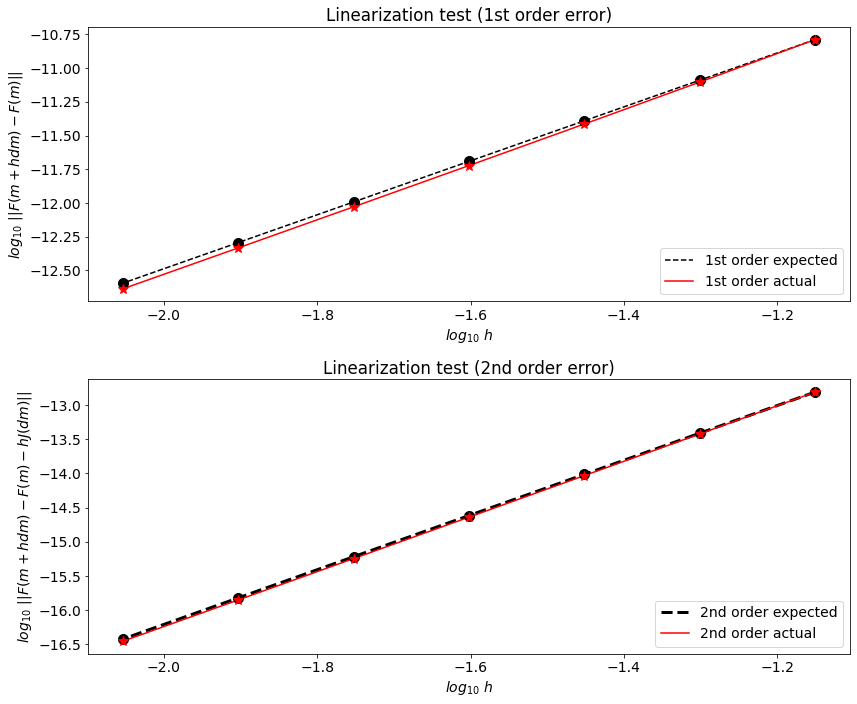

In [10]:
#NBVAL_INGNORE_OUTPUT

# Plot linearization tests
plt.figure(figsize=(12,10))

expected1 = np.empty(nstep)
expected2 = np.empty(nstep)

expected1[0] = norm1[0]
expected2[0] = norm2[0]

for kstep in range(1, nstep):
    expected1[kstep] = expected1[kstep - 1] / (dh**2)
    expected2[kstep] = expected2[kstep - 1] / (dh**4)

msize = 10

plt.subplot(2,1,1)
plt.plot(np.log10(scale), np.log10(expected1), '--k', label='1st order expected', linewidth=1.5)
plt.plot(np.log10(scale), np.log10(norm1), '-r', label='1st order actual', linewidth=1.5)
plt.plot(np.log10(scale), np.log10(expected1), 'ko', markersize=10, linewidth=3)
plt.plot(np.log10(scale), np.log10(norm1), 'r*', markersize=10, linewidth=1.5)
plt.xlabel('$log_{10}\ h$')
plt.ylabel('$log_{10}\ \|| F(m+h dm) - F(m) \||$')
plt.title('Linearization test (1st order error)')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(np.log10(scale), np.log10(expected2), '--k', label='2nd order expected',  linewidth=3)
plt.plot(np.log10(scale), np.log10(norm2), '-r', label='2nd order actual', linewidth=1.5)
plt.plot(np.log10(scale), np.log10(expected2), 'ko', markersize=10, linewidth=3)
plt.plot(np.log10(scale), np.log10(norm2), 'r*', markersize=10, linewidth=1.5)
plt.xlabel('$log_{10}\ h$')
plt.ylabel('$log_{10}\ \|| F(m+h dm) - F(m) - h J(dm)\||$')
plt.title('Linearization test (2nd order error)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## 5. Jacobian operator linearity test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\begin{aligned}
\nabla F[m; q]\ (\alpha\ \delta m) &\approx \alpha\ \nabla F[m; q]\ \delta m \\[5pt]
(\nabla F[m; q])^\top (\alpha\ \delta r) &\approx \alpha\ (\nabla F[m; q])^\top \delta r
\end{aligned}
$$

We first test the forward operator, and in the cell below that the adjoint operator.

In [11]:
#NBVAL_INGNORE_OUTPUT

src0 = solver.geometry.src

m0 = Function(name='m0', grid=solver.model.grid, space_order=8)
m1 = Function(name='m1', grid=solver.model.grid, space_order=8)
m0.data[:] = 1.5

# Model perturbation, box of random values centered on middle of model
m1.data[:] = 0
size = 5
ns = 2 * size + 1
nx2, nz2 = shape[0]//2, shape[1]//2
m1.data[nx2-size:nx2+size, nz2-size:nz2+size] = \
    -1 + 2 * np.random.rand(ns, ns)

a = np.random.rand()
rec1, _, _, _ = solver.jacobian(m1, src0, vp=m0)
rec1.data[:] = a * rec1.data[:]
m1.data[:] = a * m1.data[:]
rec2, _, _, _ = solver.jacobian(m1, src0, vp=m0)

# Normalize by rms of rec2, to enable using abolute tolerance below
rms2 = np.sqrt(np.mean(rec2.data**2))
diff = (rec1.data - rec2.data) / rms2
print("\nlinearity forward J %s (so=%d) rms 1,2,diff; "
      "%+16.10e %+16.10e %+16.10e" %
      (shape, 8, np.sqrt(np.mean(rec1.data**2)), np.sqrt(np.mean(rec2.data**2)),
       np.sqrt(np.mean(diff**2))))
tol = 1.e-12
assert np.allclose(diff, 0.0, atol=tol)


Operator `IsoJacobianFwdOperator` run in 0.55 s
Operator `IsoJacobianFwdOperator` run in 0.98 s



linearity forward J (101, 81) (so=8) rms 1,2,diff; +1.4912379866e-07 +1.4912379866e-07 +1.3599408414e-15


In [12]:
#NBVAL_INGNORE_OUTPUT

src0 = solver.geometry.src

m0 = Function(name='m0', grid=solver.model.grid, space_order=8)
m1 = Function(name='m1', grid=solver.model.grid, space_order=8)
m0.data[:] = 1.5

# Model perturbation, box of random values centered on middle of model
m1.data[:] = 0
size = 5
ns = 2 * size + 1
nx2, nz2 = shape[0]//2, shape[1]//2
m1.data[nx2-size:nx2+size, nz2-size:nz2+size] = \
    -1 + 2 * np.random.rand(ns, ns)

a = np.random.rand()
rec0, u0, _ = solver.forward(src0, vp=m0, save=True)
dm1, _, _, _ = solver.jacobian_adjoint(rec0, u0, vp=m0)
dm1.data[:] = a * dm1.data[:]
rec0.data[:] = a * rec0.data[:]
dm2, _, _, _ = solver.jacobian_adjoint(rec0, u0, vp=m0)

# Normalize by rms of rec2, to enable using abolute tolerance below
rms2 = np.sqrt(np.mean(dm2.data**2))
diff = (dm1.data - dm2.data) / rms2
print("\nlinearity adjoint J %s (so=%d) rms 1,2,diff; "
      "%+16.10e %+16.10e %+16.10e" %
      (shape, 8, np.sqrt(np.mean(dm1.data**2)), np.sqrt(np.mean(dm2.data**2)),
       np.sqrt(np.mean(diff**2))))

Operator `IsoFwdOperator` run in 0.55 s
Operator `IsoJacobianAdjOperator` run in 0.13 s
Operator `IsoJacobianAdjOperator` run in 2.34 s



linearity adjoint J (101, 81) (so=8) rms 1,2,diff; +9.2501136310e+01 +9.2501136310e+01 +7.7383268263e-16


## 6. Jacobian operator adjoint test, with respect to model perturbation and receiver wavefield perturbation 
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\delta r \cdot \nabla F[m; q]\ \delta m \approx \delta m \cdot (\nabla F[m; q])^\top \delta r
$$

<br>


In [13]:
#NBVAL_INGNORE_OUTPUT

src0 = solver.geometry.src

m0 = Function(name='m0', grid=solver.model.grid, space_order=8)
dm1 = Function(name='dm1', grid=solver.model.grid, space_order=8)
m0.data[:] = 1.5

# Model perturbation, box of random values centered on middle of model
dm1.data[:] = 0
size = 5
ns = 2 * size + 1
nx2, nz2 = shape[0]//2, shape[1]//2
dm1.data[nx2-size:nx2+size, nz2-size:nz2+size] = \
    -1 + 2 * np.random.rand(ns, ns)

# Data perturbation
rec1 = solver.geometry.rec
nt, nr = rec1.data.shape
rec1.data[:] = np.random.rand(nt, nr)

# Nonlinear modeling
rec0, u0, _ = solver.forward(src0, vp=m0, save=True)

# Linearized modeling
rec2, _, _, _ = solver.jacobian(dm1, src0, vp=m0)
dm2, _, _, _ = solver.jacobian_adjoint(rec1, u0, vp=m0)

sum_m = np.dot(dm1.data.reshape(-1), dm2.data.reshape(-1))
sum_d = np.dot(rec1.data.reshape(-1), rec2.data.reshape(-1))
diff = (sum_m - sum_d) / (sum_m + sum_d)
print("\nadjoint J %s (so=%d) sum_m, sum_d, diff; %16.10e %+16.10e %+16.10e" %
      (shape, 8, sum_m, sum_d, diff))
assert np.isclose(diff, 0., atol=1.e-11)

Operator `IsoFwdOperator` run in 0.09 s
Operator `IsoJacobianFwdOperator` run in 4.05 s


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


Operator `IsoJacobianAdjOperator` run in 1.44 s



adjoint J (101, 81) (so=8) sum_m, sum_d, diff; 7.2085320709e-05 +7.2085320709e-05 +3.7601350796e-16


## 7. Skew symmetry for shifted derivatives

Ensure for random $x_1, x_2$ that Devito shifted derivative operators $\overrightarrow{\partial_x}$ and $\overrightarrow{\partial_x}$ are skew symmetric by verifying the following dot product test.

$$
x_2 \cdot \left( \overrightarrow{\partial_x}\ x_1 \right) \approx -\ 
x_1 \cdot \left( \overleftarrow{\partial_x}\ x_2 \right) 
$$

We use Devito to implement the following two equations for random $f_1, g_1$:

$$
\begin{aligned}
f_2 = \overrightarrow{\partial_x}\ f_1 \\[5pt]
g_2 = \overleftarrow{\partial_x}\ g_1
\end{aligned}
$$

We verify passing this adjoint test by implementing the following equations for random $f_1, g_1$, and ensuring that the relative error terms vanishes.

$$
\begin{aligned}
f_2 = \overrightarrow{\partial_x}\ f_1 \\[5pt]
g_2 = \overleftarrow{\partial_x}\ g_1 \\[7pt]
\frac{\displaystyle f_1 \cdot g_2 + g_1 \cdot f_2}
     {\displaystyle f_1 \cdot g_2 - g_1 \cdot f_2}\ <\ \epsilon
\end{aligned}
$$

In [14]:
#NBVAL_INGNORE_OUTPUT

# Make 1D grid to test derivatives 
n = 101
d = 1.0
shape = (n, )
spacing = (1 / (n-1), )   
origin = (0., )
extent = (d * (n-1), )
dtype = np.float64

# Initialize Devito grid and Functions for input(f1,g1) and output(f2,g2)
# Note that space_order=8 allows us to use an 8th order finite difference 
#   operator by properly setting up grid accesses with halo cells 
grid1d = Grid(shape=shape, extent=extent, origin=origin, dtype=dtype)
x = grid1d.dimensions[0]
f1 = Function(name='f1', grid=grid1d, space_order=8)
f2 = Function(name='f2', grid=grid1d, space_order=8)
g1 = Function(name='g1', grid=grid1d, space_order=8)
g2 = Function(name='g2', grid=grid1d, space_order=8)

# Fill f1 and g1 with random values in [-1,+1]
f1.data[:] = -1 + 2 * np.random.rand(n,)
g1.data[:] = -1 + 2 * np.random.rand(n,)

# Equation defining: [f2 = forward 1/2 cell shift derivative applied to f1]
equation_f2 = Eq(f2, f1.dx(x0=x+0.5*x.spacing))

# Equation defining: [g2 = backward 1/2 cell shift derivative applied to g1]
equation_g2 = Eq(g2, g1.dx(x0=x-0.5*x.spacing))

# Define an Operator to implement these equations and execute
op = Operator([equation_f2, equation_g2])
op()

# Compute the dot products and the relative error
f1g2 = np.dot(f1.data, g2.data)
g1f2 = np.dot(g1.data, f2.data)
diff = (f1g2+g1f2)/(f1g2-g1f2)

tol = 100 * np.finfo(dtype).eps
print("f1g2, g1f2, diff, tol; %+.6e %+.6e %+.6e %+.6e" % (f1g2, g1f2, diff, tol))

# At last the unit test
# Assert these dot products are float epsilon close in relative error
assert diff < 100 * np.finfo(np.float32).eps

Operator `Kernel` run in 0.01 s


f1g2, g1f2, diff, tol; +7.083495e-01 -7.083495e-01 -2.351007e-16 +2.220446e-14


## Discussion

This concludes the correctness testing of the skew symmetric isotropic visco- acoustic operator. Note that you can run the unit tests directly with the following command, where ```-s``` outputs information about the tolerance and tested values in the tests.

```pytest -s test_wavesolver_iso.py```  

If you would like to continue this tutorial series with the VTI and TTI operators, please see the README for links. 

- [README.md](README.md)

## References

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1
